In [3]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1.加载数据

In [4]:
X_train = pd.read_csv("input/train.csv", nrows=1000000, parse_dates=['click_time'])

# 2.创建特征
## 2.1 提取时间信息
首先从click_time提取day、minute、hour、second

In [5]:
X_train['day'] = X_train['click_time'].dt.day.astype('uint8')
X_train['hour'] = X_train['click_time'].dt.hour.astype('uint8')
X_train['minute'] = X_train['click_time'].dt.minute.astype('uint8')
X_train['second'] = X_train['click_time'].dt.second.astype('uint8')
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,32,21
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,33,34
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,34,12
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,34,52
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,35,8


In [9]:
ATTRIBUTION_CATEGORIES = [
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    ['channel', 'os'],
    ['channel', 'device'],
    ['os', 'device']
]

freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    new_feature = '_'.join(cols) + '_confRate'
    
    group_object = X_train.groupby(cols)
    
    group_sizes = group_object.size()
    log_group = np.log(10000)
    print(">> Calculating confidence-weighted rate for: {}.\n Saving to: {}. Group Max /Mean /Median / Min: {} / {} / {}/ {}".
         format(cols, new_feature, group_sizes.max(), np.round(group_sizes.mean(), 2), np.round(group_sizes.median(), 2), group_sizes.min()))
    
    def rate_calculation(x):
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count())/log_group])
        return rate * conf
    
    X_train = X_train.merge(group_object['is_attributed'].apply(rate_calculation).reset_index().rename(index=str, columns={'is_attributed': new_feature})[cols + [new_feature]],
                           on=cols, how='left')
    X_train.head()

>> Calculating confidence-weighted rate for: ['ip'].
 Saving to: ip_confRate. Group Max /Mean /Median / Min: 6437 / 25.25 / 10.0/ 1
>> Calculating confidence-weighted rate for: ['app'].
 Saving to: app_confRate. Group Max /Mean /Median / Min: 141851 / 4672.9 / 12.0/ 1
>> Calculating confidence-weighted rate for: ['device'].
 Saving to: device_confRate. Group Max /Mean /Median / Min: 938053 / 3355.7 / 1.0/ 1
>> Calculating confidence-weighted rate for: ['os'].
 Saving to: os_confRate. Group Max /Mean /Median / Min: 239642 / 6250.0 / 38.0/ 1
>> Calculating confidence-weighted rate for: ['channel'].
 Saving to: channel_confRate. Group Max /Mean /Median / Min: 92534 / 6493.51 / 1200.0/ 1
>> Calculating confidence-weighted rate for: ['app', 'channel'].
 Saving to: app_channel_confRate. Group Max /Mean /Median / Min: 61413 / 1915.71 / 18.0/ 1
>> Calculating confidence-weighted rate for: ['app', 'os'].
 Saving to: app_os_confRate. Group Max /Mean /Median / Min: 34853 / 352.24 / 8.0/ 1
>> Calc

## 2.3 Group-By聚合

In [13]:
# Define all the groupby transformations
GROUPBY_AGGREGATIONS = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    
    # V2 - GroupBy Features #
    #########################
    # Average clicks on app by distinct users; is it an app they return to?
    {'groupby': ['app'], 
     'select': 'ip', 
     'agg': lambda x: float(len(x)) / len(x.unique()), 
     'agg_name': 'AvgViewPerDistinct'
    },
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'}, 
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'}    
]

for spec in GROUPBY_AGGREGATIONS:
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    print ("grouping by {}, and aggregating {} with {}".format(spec['groupby'], spec['select'], agg_name))
    
    all_features = list(set(spec['groupby'] + [spec['select']]))
    gp = X_train[all_features].groupby(spec['groupby'])[spec['select']].agg(spec['agg']).reset_index().rename(index=str, columns={spec['select']: new_feature})
    
    if 'cumcount' == spec['agg']:
        X_train[new_feature] = gp[0].values
    else:
         X_train = X_train.merge(gp, on=spec['groupby'], how='left')
    
    del gp
    gc.collect()

X_train.head()
        

grouping by ['ip', 'app', 'channel'], and aggregating day with var
grouping by ['ip', 'app', 'os'], and aggregating hour with var
grouping by ['ip', 'day', 'channel'], and aggregating hour with var
grouping by ['ip', 'day', 'hour'], and aggregating channel with count
grouping by ['ip', 'app'], and aggregating channel with count
grouping by ['ip', 'app', 'os'], and aggregating channel with count
grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
grouping by ['app'], and aggregating ip with AvgViewPerDistinct
grouping by ['app'], and aggregating channel with count
grouping by ['channel'], and aggregating app with count
grouping by ['ip'], and aggregating channel with nunique
grouping by ['ip'], and aggregating app with nunique
grouping by ['ip', 'day'], and aggregating hour with nunique
grouping by ['ip', 'app'], and aggregating os with nunique
grouping by ['ip'], and aggregating device with nu

In [17]:
GROUP_BY_NEXT_CLICKS = [
    
    # V1
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    {'groupby': ['ip', 'os']},
    
    # V3
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']}
]

for spec in GROUP_BY_NEXT_CLICKS:
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))
    
    all_features = spec['groupby'] + ['click_time']
    
    print (">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}" )
    X_train[new_feature] = X_train[all_features].groupby(spec['groupby']).click_time.transform(lambda x : x.diff().shift(-1)).dt.seconds
X_train.head()

>> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}
>> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}
>> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}
>> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}
>> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}
>> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}
>> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,ip_cumcount_app,ip_cumcount_os,ip_day_channel_var_hour_y,ip_nextClick,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,...,0,0,1.333333,5290.0,5340.0,5444.0,5307.0,NaN,5307.0,5340.0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,...,0,0,1.000000,5177.0,5177.0,5177.0,5239.0,NaN,5239.0,5547.0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,...,0,0,2.000000,5175.0,5175.0,6005.0,5205.0,NaN,5205.0,5925.0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,...,0,0,1.000000,5108.0,5110.0,5137.0,5108.0,NaN,5108.0,5110.0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

for fname, fset in HISTORY_CLICKS.items():
    X_train['prev_' + fname] = X_train.groupby(fset).cumcount().rename('prev_' + fname)
    X_train['future_' + fname] = X_train.iloc[::-1].groupby(fset).cumcount().rename('future_' + fname).iloc[::-1]
X_train.head()
    

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_channel_nextClick,ip_os_device_nextClick,ip_os_device_app_nextClick,prev_identical_clicks,future_identical_clicks,prev_app_clicks,future_app_clicks
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,...,5340.0,5444.0,5307.0,NaN,5307.0,5340.0,0,0,0,18
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,...,5177.0,5177.0,5239.0,NaN,5239.0,5547.0,0,0,0,22
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,...,5175.0,6005.0,5205.0,NaN,5205.0,5925.0,0,0,0,9
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,...,5110.0,5137.0,5108.0,NaN,5108.0,5110.0,0,0,0,68
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


# 3.评价特征重要性

In [22]:
import xgboost as xgb

y = X_train['is_attributed']
X = X_train.drop('is_attributed', axis=1).select_dtypes(include=[np.number])

clf_xgBoost = xgb.XGBClassifier(
    max_depth = 4,
    subsample=0.8,
    colsample_bytree=0.7,
    colsample_bylevel=0.7,
    scale_pos_weight=9,
    min_child_weight=0,
    reg_alpha=4,
    n_jobs=4,
    objective='binary:logistic'
)
clf_xgBoost.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=0, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=4, reg_lambda=1, scale_pos_weight=9, seed=None,
       silent=True, subsample=0.8)

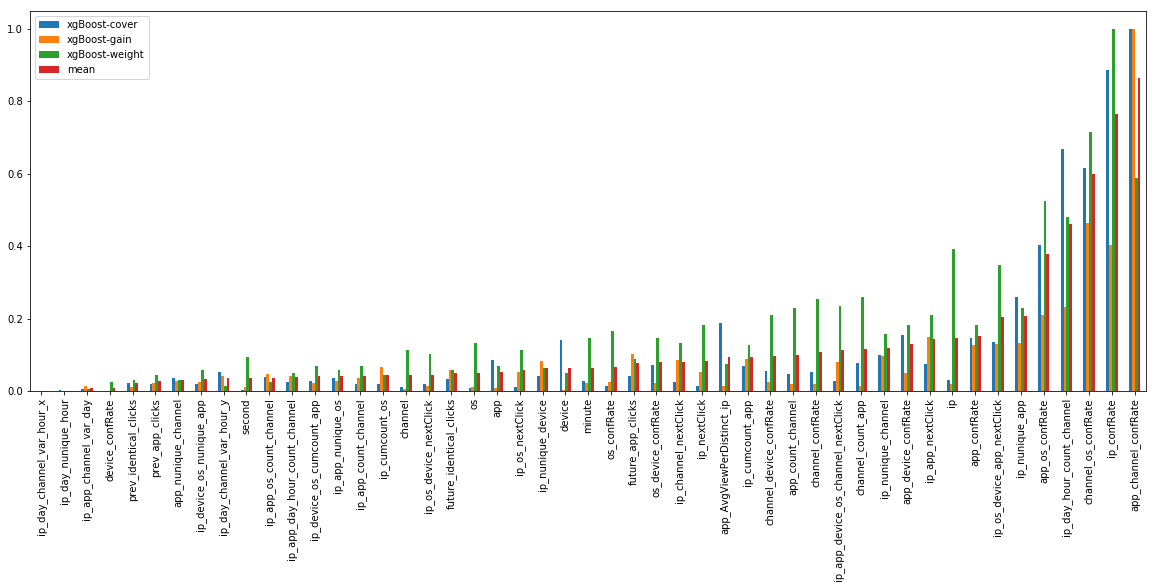

In [24]:
from sklearn import preprocessing

importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf_xgBoost.get_booster().get_score(importance_type=import_type)
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns = importance_df.columns,
    index=importance_df.index
)
importance_df['mean'] = importance_df.mean(axis=1)

importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))